# Feature Engineering
## Seth Adams

### Merged train and test files. Found repeat images.

I found 67 repeated images after merging the train and test sets. It appears as though these images might be correctly classified for one class but then wrong for another. These repeats will be stored in a pickle for reference. See an example case in the image below.

In [1]:
import pickle

with open('class_map.pickle', 'rb') as handle:
    class_map = pickle.load(handle)

print(class_map.items())
    
with open('repeats.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

print('{} repeats found'.format(len(pairs.keys())))
for k, v in pairs.items():
    print('Repeated image found: {} in classes: {}'.format(k, v))

dict_items([(0, 'Acartia'), (1, 'Aglantha'), (2, 'Beroe'), (3, 'Blob'), (4, 'Bolinopsis'), (5, 'Calanus'), (6, 'Chaetognatha'), (7, 'Clytia'), (8, 'Cnidaria'), (9, 'Cope_lg'), (10, 'Cope_sm'), (11, 'Ctenophora'), (12, 'Doliolida'), (13, 'Dot'), (14, 'Filament'), (15, 'Filaments'), (16, 'Furcilia'), (17, 'Larvacea'), (18, 'Limacina'), (19, 'Metridia'), (20, 'Nauplius'), (21, 'Neocalanus'), (22, 'Oikopleura'), (23, 'Oithona'), (24, 'Paraeuchaeta'), (25, 'Parasagitta'), (26, 'Pleurobrachia'), (27, 'Pluteus'), (28, 'Polychaeta'), (29, 'Poorlysegmented'), (30, 'Pseudocalanus'), (31, 'Radiolarian'), (32, 'Siphonophora'), (33, 'Snow'), (34, 'Spionidae'), (35, 'Spiral'), (36, 'Unknown')])
67 repeats found
Repeated image found: SPC-PWSSC-0-000836-087-324-2296-108-80.png in classes: [0, 10]
Repeated image found: SPC-PWSSC-1465378392-000750-049-3772-2036-279-484.png in classes: [2, 11]
Repeated image found: SPC-PWSSC-1459783706-000825-186-2838-920-64-116.png in classes: [3, 10]
Repeated image fou

![Repeat image](ipynb_files/repeat_example.png)

### Demo of Segmentation class

Image workflow:

Segment plankton --> Crop to segmenation --> Resize with major axis and aspect ratio --> Pad zeros to target size

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from segmentation import Segmentation

data_path = os.path.join(os.getcwd(), 'data')
class_path = os.path.join(data_path, 'Doliolida')
im_path = os.path.join(class_path, 'SPC-PWSSC-1468186366-000556-041-352-1182-520-1216.png')

im_bgr = cv2.imread(im_path, -1)
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.show()

<Figure size 640x480 with 1 Axes>

Image cleaning for segmentation is performed:

- Image is converted to grayscale
- Pixels above 1 are thresholded up to 255 (white)
- A gaussian blur is applied using a (5, 5) kernel size
- An ellipse structuring element is used with (3, 3) kernel to perform closing and opening on the image
- Contours are detected. Only keeping the largest contour found

The largest contour is used to produce the following:

- 2D mask of the image (mask)
- An overlay mask where the 2D mask is made transparent over the original image (overlay)
- A segmented version of the image with drawings of features and contour (segmented)
- A padded version of the image which centers a crop from contour and pads to a specified shape (padded)

Images are returned in RGB format (needed for matplotlib.imshow)

In [3]:
plankton = Segmentation(im_path, target_shape=(299, 299, 3))
plankton.segment()
mask = plankton.get_mask()
overlay = plankton.get_overlay()
segmented = plankton.get_segmented()

Unfortunately matplotlib.imshow does a poor job plotting these images. Here is a picture of all the transformations.


![segment_demo_1](ipynb_files/segment_example.png)

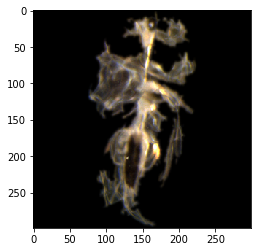

In [4]:
padded = plankton.get_padded()
plt.imshow(padded)
plt.show()

Notice how the segmented portion has been padded to the center to match the target_shape of (299, 299, 3) for inception_v3

This will ensure consistent image size for any neural network. Original image size has been preserved in the calculated features.

### Demo of padded (One for each class)

In [5]:
df = pd.read_csv('plankton.csv')
df.sample(5)

,im_name,label
8261,SPC-PWSSC-0-000883-024-20-2480-104-72.png,36
1672,SPC-PWSSC-1460086073-000697-045-934-2026-88-48...,3
675,SPC-PWSSC-1459783722-000882-282-3506-1390-68-8...,3
4839,SPC-PWSSC-1466976707-000370-098-1440-338-64-92...,10
7737,SPC-PWSSC-1469093569-000515-015-1902-2164-84-6...,30


In [6]:
def plot_images(images):
    fig, axes = plt.subplots(nrows=6, ncols=6, sharex=False,
                             sharey=True, figsize=(14,14))
    fig.suptitle('Padded Plankton', size=20)
    i = 0
    for x in range(6):
        for y in range(6):
            axes[x,y].imshow(images[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

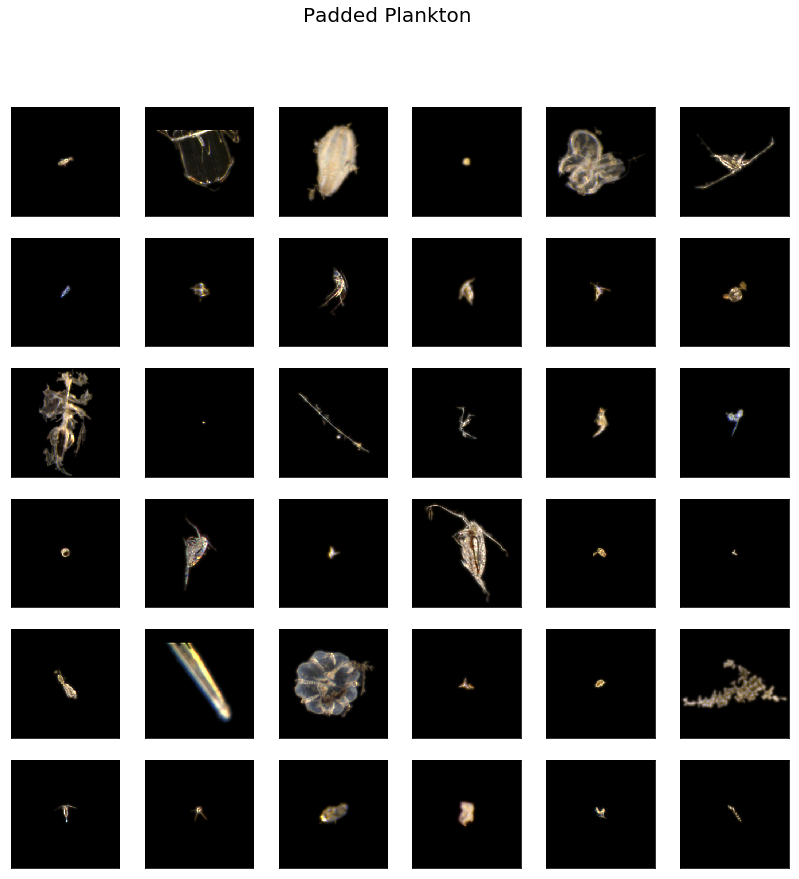

In [7]:
data_path = os.path.join(os.getcwd(), 'data')

images = []
for c in list(class_map.keys())[:-1]:
    im_name = df[df.label==c].iloc[0,0]
    im_dir = os.path.join(data_path, list(class_map.values())[c])
    im_path = os.path.join(im_dir, im_name)
    plankton = Segmentation(im_path)
    plankton.segment()
    padded = plankton.get_padded()
    images.append(padded)

plot_images(images)
plt.show()

### An example use case of calculated features.


Features are calculated on the segmented plankton:
- x_length and y_length (2)
- area (1)
- hu moments (7)
- haralick textures (13)
- local binary patterns (36)
- threshold adjacency statistics (54)



10823
10823
Counter({3: 3151, 36: 2594, 10: 789, 9: 586, 14: 572, 21: 436, 5: 294, 30: 194, 23: 180, 19: 168, 8: 167, 33: 151, 26: 150, 32: 142, 22: 129, 13: 123, 1: 114, 35: 113, 18: 82, 20: 79, 15: 70, 29: 63, 12: 54, 11: 51, 17: 49, 4: 43, 16: 35, 27: 35, 7: 31, 6: 26, 25: 25, 0: 24, 24: 24, 34: 22, 28: 20, 31: 20, 2: 17})


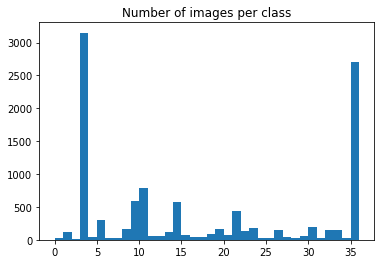

In [8]:
from collections import Counter

print(df.shape[0])
for i, name in enumerate(df.im_name):
    if name in list(pairs.keys()):
        df.drop(i, inplace=True)
print(df.shape[0])
   
counter = Counter(df.label)
print(counter)

plt.title('Number of images per class')
plt.hist(df.label, bins=np.arange(0,len(class_map.keys()), 1))
plt.show()

Removing all duplicate image names, 134 images drop out of the dataframe. The histogram shows severe class imbalance. In order to create some balanced sample data, I will only use 17 examples from each class.

In [9]:
frames = []

for c in range(len(counter)):
    frames.append(df[df.label==c].sample(n=17))

df_sample = pd.concat(frames)
df_sample = df_sample.reset_index(drop=True)
df_sample.sample(10)

,im_name,label
554,SPC-PWSSC-1470173599-000635-164-2908-1070-152-...,32
267,SPC-PWSSC-1470691999-000636-108-2054-500-120-1...,15
17,SPC-PWSSC-1474580076-000780-067-1514-2342-244-...,1
483,SPC-PWSSC-0-000074-007-1018-1104-60-48.png,28
509,SPC-PWSSC-1468272804-000704-364-2532-410-304-5...,29
74,SPC-PWSSC-1476783241-000566-358-126-576-292-26...,4
144,SPC-PWSSC-1473327155-000353-007-0-2232-1072-33...,8
125,SPC-PWSSC-1467754379-000600-033-1048-1694-728-...,7
35,SPC-PWSSC-1466933424-000033-044-2784-0-656-204...,2
141,SPC-PWSSC-1468359180-000607-019-530-2054-256-2...,8


In [10]:
frames = []

for im_name, label in zip(df_sample.im_name, df_sample.label):
    dir_name = class_map[label]
    dir_path = os.path.join(data_path, dir_name)
    im_path = os.path.join(dir_path, im_name)
    
    plankton = Segmentation(im_path)
    plankton.segment()
    features = plankton.get_features()
    frames.append(features)
    
columns = plankton.get_columns()

df_features = pd.DataFrame(data=frames, columns=columns)
df_features['label'] = df_sample.label
df_features.sample(10)

,x_length,y_length,area,haralick_0,haralick_1,haralick_2,haralick_3,haralick_4,haralick_5,haralick_6,haralick_7,haralick_8,haralick_9,haralick_10,haralick_11,haralick_12,label
556,6.129050,5.231109,10.259307,0.474156,47.651635,0.983050,1404.795789,0.751208,31.096973,5571.531522,3.383548,4.435334,0.001997,2.080704,-0.538424,0.980113,32
498,5.164786,5.332719,10.034077,0.147071,104.209017,0.986268,3793.514419,0.470263,112.797499,15069.848659,6.222578,8.694053,0.000778,3.590952,-0.442586,0.996237,29
83,6.493754,6.361302,12.447885,0.115431,35.676538,0.997450,6995.146702,0.480086,190.553844,27944.910270,6.657713,9.055877,0.000747,3.243122,-0.487220,0.998453,4
142,6.182085,5.556828,10.334100,0.604359,41.999067,0.972443,761.676665,0.820582,17.812635,3004.707591,2.452486,3.231104,0.002526,1.656097,-0.517304,0.945726,8
474,3.637586,4.343805,7.628274,0.122893,172.193608,0.967605,2650.777119,0.449698,66.223006,10430.914869,5.925794,7.492956,0.000651,3.851529,-0.575288,0.998794,27
310,3.610918,3.688879,7.025094,0.106510,196.513854,0.943047,1720.631813,0.417454,51.472682,6686.013399,5.803994,7.421191,0.000578,4.005962,-0.545370,0.998062,18
603,4.262680,3.465736,7.482963,0.077156,147.489982,0.964830,2092.422967,0.378413,67.644255,8222.201888,6.330319,8.076709,0.000564,4.110827,-0.551756,0.998907,35
44,5.236442,5.659482,10.682044,0.042345,35.269151,0.998126,9416.892670,0.409057,276.753569,37632.301530,7.331201,9.747679,0.000561,3.388180,-0.503202,0.999236,2
371,4.905275,5.049856,9.307739,0.257512,88.888820,0.986373,3259.216523,0.577303,72.098609,12947.977271,5.145458,6.919774,0.001180,3.166121,-0.496594,0.994731,21
369,4.969813,5.501258,9.437755,0.446325,37.170269,0.987092,1438.502082,0.732850,34.895269,5716.838061,3.560793,4.592259,0.001977,2.156715,-0.559654,0.985580,21


(629, 16) (629,)
Logistic Regression: 0.3751987281399046
K Nearest Neighbors: 0.47058823529411764
Random Forests: 1.0
Multilayer Perceptron: 0.45310015898251194


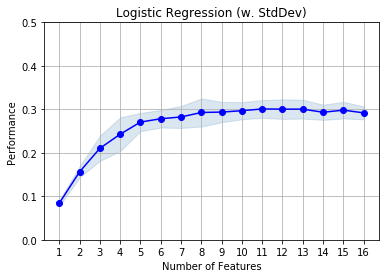

    avg_score    ci_bound                                          cv_scores  \
1   0.0842342  0.00889415  [0.08783783783783784, 0.08108108108108109, 0.0...   
2    0.156306    0.016128  [0.14864864864864866, 0.1554054054054054, 0.15...   
3     0.21036   0.0371438  [0.16891891891891891, 0.21621621621621623, 0.2...   
4    0.242793   0.0497501  [0.22972972972972974, 0.2635135135135135, 0.29...   
5    0.270721   0.0269325  [0.24324324324324326, 0.2905405405405405, 0.29...   
6    0.278378   0.0259952  [0.2702702702702703, 0.28378378378378377, 0.31...   
7    0.282432   0.0324218  [0.28378378378378377, 0.2905405405405405, 0.32...   
8    0.292793   0.0415482  [0.3310810810810811, 0.30405405405405406, 0.28...   
9    0.293694   0.0300613  [0.3108108108108108, 0.28378378378378377, 0.31...   
10   0.296847   0.0252628  [0.3108108108108108, 0.2905405405405405, 0.315...   
11   0.300901   0.0262519  [0.3108108108108108, 0.28378378378378377, 0.32...   
12    0.30045   0.0289248  [0.3108108108

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

X = df_features.iloc[:,:-1].values
y = df_features.iloc[:,-1].values

print(X.shape, y.shape)

sc = StandardScaler()
X = sc.fit_transform(X)

lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=4)
rf = RandomForestClassifier(n_estimators=100)
mlp = MLPClassifier(max_iter=1000)

names = ['Logistic Regression', 'K Nearest Neighbors',
         'Random Forests', 'Multilayer Perceptron']
classifiers = [lr, knn, rf, mlp]

for name, cls in zip(names, classifiers):
    cls.fit(X,y)
    print('{}: {}'.format(name, cls.score(X,y)))

lr = LogisticRegression()
sfs = SFS(lr, 
          k_features=X.shape[1],
          forward=True, 
          floating=True, 
          verbose=0,
          scoring='accuracy',
          cv=5)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.0, 0.5])
plt.title('Logistic Regression (w. StdDev)')
plt.grid()
plt.show()

df_results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
print(df_results)

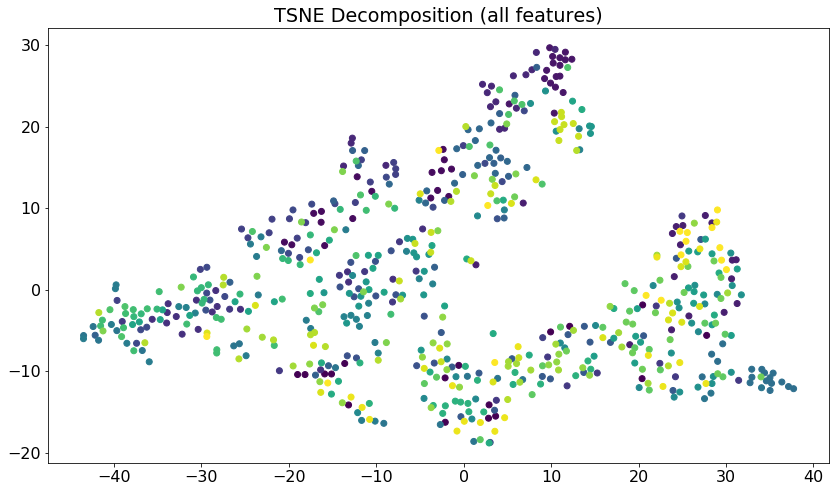

In [12]:
from sklearn.manifold import TSNE
import matplotlib as mpl

mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (14,8)
mpl.rcParams['axes.labelsize'] = 16

X_tsne = TSNE(n_components=2).fit_transform(X)

plt.title('TSNE Decomposition (all features)')
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.show()

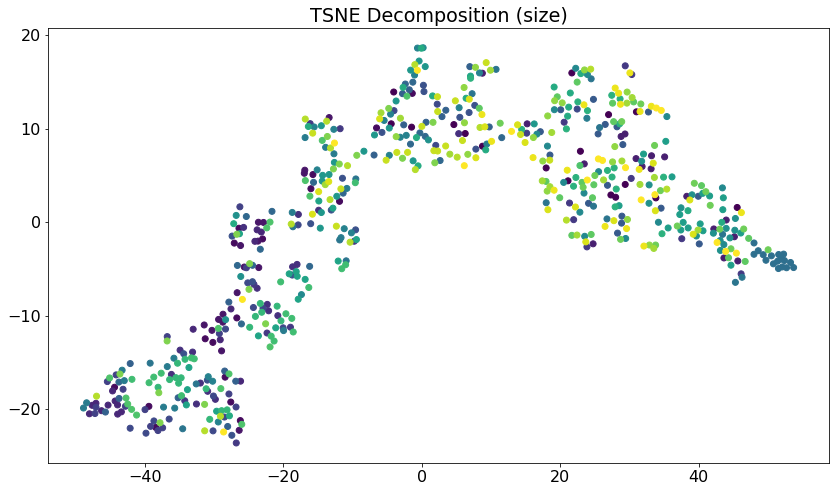

In [13]:
X_tsne = TSNE(n_components=2).fit_transform(X[:,:3])
plt.title('TSNE Decomposition (size)')
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.show()

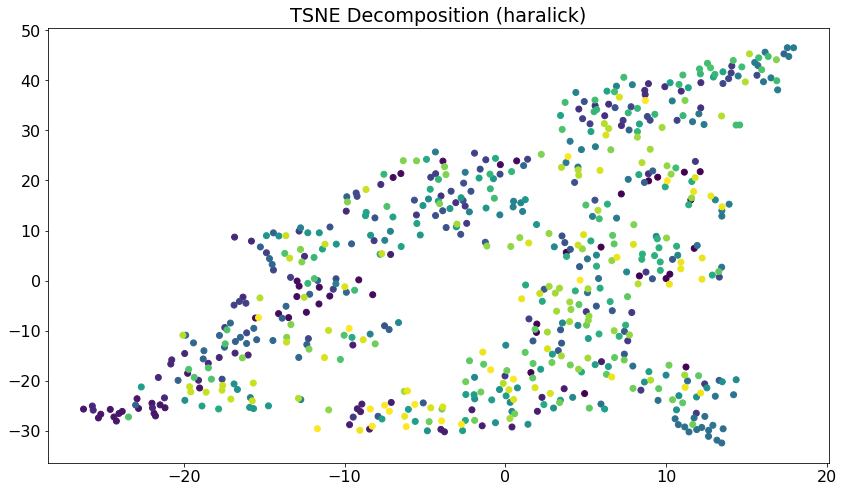

In [14]:
X_tsne = TSNE(n_components=2).fit_transform(X[:,3:16])
plt.title('TSNE Decomposition (haralick)')
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.show()

### Conclusion

Data size used here is too small for appropriate modeling. I'm going to need to do some transformations on the images to build up a bigger data size. I used logistic regression wtih sequential feature selection due to it's simplistic nature. The sampling is random, so sometimes different features are selected before others. I made t-SNE decompositions to try and check for some degree of separation in the classes. Using only the size based features, you can start to see clear groupings of certain data points. The haralick only tsne also shows some good clustering. Using the whole feature set of 113 features seems excessive. Data points don't cluster as well as in the reduced feature plots. In my opinion it is probably best to discard local binary patterns and threshold adjacency statistics when merging into a neural network. I would prefer the features to be learned through convolutions and then merge with size estimation features to complete the model.